This is a starter notebook for the project, you'll have to import the libraries you'll need, you can find a list of the ones available in this workspace in the requirements.txt file in this workspace.

## Installation

In [1]:
!pip install -r  requirements.txt

  Using cached langchain-0.1.10-py3-none-any.whl (806 kB)
  Using cached langchain_community-0.0.25-py3-none-any.whl (1.8 MB)
  Using cached langchain_core-0.1.28-py3-none-any.whl (252 kB)
  Using cached langchain_experimental-0.0.53-py3-none-any.whl (173 kB)
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.1.52
    Uninstalling langchain-core-0.1.52:
      Successfully uninstalled langchain-core-0.1.52
  Attempting uninstall: langchain-community
    Found existing installation: langchain-community 0.0.38
    Uninstalling langchain-community-0.0.38:
      Successfully uninstalled langchain-community-0.0.38
  Attempting uninstall: langchain
    Found existing installation: langchain 0.1.20
    Uninstalling langchain-0.1.20:
      Successfully uninstalled langchain-0.1.20
  Attempting uninstall: langchain-experimental
    Found existing installation: langchain-experimental 0.0.58
    Uninstalling langchain-experimental-0.0.58:
      Successfully un

In [2]:
!pip install openai==0.28

In [3]:
from langchain.llms import OpenAI

In [4]:
import torch
from langchain.chains import ConversationalRetrievalChain
from langchain.chains.question_answering import load_qa_chain
from langchain.document_loaders import DirectoryLoader
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.llms import HuggingFacePipeline
from langchain.memory import ConversationBufferMemory
from langchain.prompts import PromptTemplate
from langchain.text_splitter import CharacterTextSplitter
from langchain.vectorstores import Chroma
from transformers import AutoTokenizer, GenerationConfig, TextStreamer, pipeline

## Settings

In [5]:
MODEL_NAME = 'gpt-4-turbo'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
IMAGES_DIR = 'images'


In [6]:
model = OpenAI(model_name=MODEL_NAME, api_key="YOUR_API_KEY", temperature=0)

generation_prompt = """User
Generate exactly twenty real estate listings rows from USA locales. All the prices should be in dollars, Place should be in USA. Here are sample listing:

Neighborhood: Malibu, California, USA
Price (USD): $1,200,000
Bedrooms: 4
Bathrooms: 3.5
House Size (sqft): 2,800
Description: Welcome to your coastal retreat in Malibu, California! This stunning residence offers 4 bedrooms, 3.5 bathrooms, and panoramic views of the Pacific Ocean. With an open-concept living area, gourmet kitchen, and expansive deck overlooking the ocean, it provides the perfect blend of luxury and beachfront living. Step outside to enjoy direct access to the sandy beach, or relax in the private hot tub while watching the sunset over the water. This is coastal living at its finest.
Neighborhood Description: Malibu, California, USA, epitomizes coastal luxury with its pristine beaches, rugged cliffs, and upscale amenities. Nestled along the iconic Pacific Coast Highway, this affluent enclave offers a unique blend of natural beauty, cultural attractions like the Getty Villa, and a laid-back beach lifestyle. With its stunning vistas and commitment to environmental stewardship, Malibu captivates residents and visitors alike with its quintessential California charm.

Neighborhood: Manhattan, New York City, USA
Price (USD): $2,500,000
Bedrooms: 3
Bathrooms: 2.5
House Size (sqft): 2,000
Description: Welcome to your urban oasis in the heart of Manhattan! This luxurious apartment offers 3 bedrooms, 2.5 bathrooms, and breathtaking views of the city skyline. With floor-to-ceiling windows, a modern kitchen with top-of-the-line appliances, and a spacious living area perfect for entertaining, it epitomizes upscale city living. Step out onto the private balcony to take in the bustling city below, or unwind in the building's exclusive rooftop lounge while enjoying panoramic views of Manhattan. This is urban living at its finest.
Neighborhood Description: Manhattan, New York City, USA, stands as the beating heart of one of the world's most iconic urban landscapes. With its towering skyscrapers, bustling streets, and diverse neighborhoods, Manhattan embodies the energy and dynamism of the Big Apple. From the iconic landmarks of Times Square and Central Park to the cultural hubs of Broadway and the Museum Mile, Manhattan offers a vibrant tapestry of arts, entertainment, and culinary delights, attracting millions of visitors from around the globe each year. In the midst of its fast-paced lifestyle, Manhattan maintains a sense of community and resilience, with neighborhoods like Greenwich Village, Harlem, and the Upper West Side each contributing to the city's rich tapestry of culture and history.


Make sure the property description talks about why it's nice, like if it's good for the environment or has cozy rooms. Also, describe the neighborhood well. Talk about things like parks, shops with organic food, cafes, how easy it is to get around with public transport, and if the area cares about helping the environment.

Format the CSV with clear titles for each part. Use the same style as the example to list exactly 20 different properties. Make sure you don't generate any less than 20 listing.
"""


/usr/local/lib/python3.10/dist-packages/langchain_community/llms/openai.py:249: UserWarning: You are trying to use a chat model. This way of initializing it is no longer supported. Instead, please use: `from langchain_community.chat_models import ChatOpenAI`
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/langchain_community/llms/openai.py:1070: UserWarning: You are trying to use a chat model. This way of initializing it is no longer supported. Instead, please use: `from langchain_community.chat_models import ChatOpenAI`
  warnings.warn(


In [7]:
from typing import List
from langchain_core.pydantic_v1 import BaseModel

from langchain.output_parsers import PydanticOutputParser

class RealEstate(BaseModel):
    neighborhood: str
    price: str
    bedrooms: str
    bathrooms: str
    house_size: str
    description: str
    neighborhood_description: str

class ListingCollection(BaseModel):
    listings: List[RealEstate]


parser = PydanticOutputParser(pydantic_object=ListingCollection)

prompt = PromptTemplate(
    template="{instruction}\n{format_instructions}\n",
    input_variables=["instruction"],
    partial_variables={"format_instructions": parser.get_format_instructions},
)



In [8]:
chain = prompt | model | parser
result = chain.invoke({"instruction": generation_prompt})


In [11]:
from fastapi.encoders import jsonable_encoder

listings = jsonable_encoder(result.listings)

df = pd.DataFrame(listings)

df.to_csv("real_estate_listings.csv", index=True)
print("CSV file 'real_estate_listings.csv' has been created.")

CSV file 'real_estate_listings.csv' has been created.


In [8]:
import pandas as pd

df = pd.read_csv('real_estate_listings.csv')
df.head()

,Unnamed: 0,neighborhood,price,bedrooms,bathrooms,house_size,description,neighborhood_description
0,0,"Malibu, California, USA","$1,200,000",4,3.5,"2,800 sqft","Welcome to your coastal retreat in Malibu, Cal...","Malibu, California, USA, epitomizes coastal lu..."
1,1,"Manhattan, New York City, USA","$2,500,000",3,2.5,"2,000 sqft",Welcome to your urban oasis in the heart of Ma...,"Manhattan, New York City, USA, stands as the b..."
2,2,"Aspen, Colorado, USA","$3,400,000",5,4.0,"3,500 sqft",Experience the ultimate mountain living in Asp...,"Aspen, Colorado, USA, is renowned for its stun..."
3,3,"Palo Alto, California, USA","$2,800,000",4,3.0,"2,600 sqft",Discover modern living in the heart of Silicon...,"Palo Alto, California, USA, is a global center..."
4,4,"Charleston, South Carolina, USA","$1,150,000",3,2.5,"2,200 sqft",Embrace the charm of the South with this beaut...,"Charleston, South Carolina, USA, is known for ..."


In [9]:
df.rename(columns={'Unnamed: 0': 'id'}, inplace=True)

In [10]:
df.head()

,id,neighborhood,price,bedrooms,bathrooms,house_size,description,neighborhood_description
0,0,"Malibu, California, USA","$1,200,000",4,3.5,"2,800 sqft","Welcome to your coastal retreat in Malibu, Cal...","Malibu, California, USA, epitomizes coastal lu..."
1,1,"Manhattan, New York City, USA","$2,500,000",3,2.5,"2,000 sqft",Welcome to your urban oasis in the heart of Ma...,"Manhattan, New York City, USA, stands as the b..."
2,2,"Aspen, Colorado, USA","$3,400,000",5,4.0,"3,500 sqft",Experience the ultimate mountain living in Asp...,"Aspen, Colorado, USA, is renowned for its stun..."
3,3,"Palo Alto, California, USA","$2,800,000",4,3.0,"2,600 sqft",Discover modern living in the heart of Silicon...,"Palo Alto, California, USA, is a global center..."
4,4,"Charleston, South Carolina, USA","$1,150,000",3,2.5,"2,200 sqft",Embrace the charm of the South with this beaut...,"Charleston, South Carolina, USA, is known for ..."


In [11]:
from pathlib import Path


questions_dir = Path("chroma")
questions_dir.mkdir(exist_ok=True, parents=True)


def write_file(question, answer, file_path):
    text = f"""
Q: {question}
A: {answer}
""".strip()
    with Path(questions_dir / file_path).open("w") as text_file:
        text_file.write(text)

In [12]:
import os
from PIL import Image

property_texts = []

property_ids = [{'id': i} for i in range(len(df))]

property_template = """
Description: {}
Neighborhood Description: {}
Price: {}
Bedrooms: {}
Bathrooms: {}
House Size (sqft): {}
"""

for index, row in df.iterrows():
    property_texts.append(property_template.format(
        row['description'],
        row['neighborhood_description'],
        row['price'],
        row['bedrooms'],
        row['bathrooms'],
        row['house_size']
    ))


In [13]:
property_texts

['\nDescription: Welcome to your coastal retreat in Malibu, California! This stunning residence offers 4 bedrooms, 3.5 bathrooms, and panoramic views of the Pacific Ocean. With an open-concept living area, gourmet kitchen, and expansive deck overlooking the ocean, it provides the perfect blend of luxury and beachfront living. Step outside to enjoy direct access to the sandy beach, or relax in the private hot tub while watching the sunset over the water. This is coastal living at its finest.\nNeighborhood Description: Malibu, California, USA, epitomizes coastal luxury with its pristine beaches, rugged cliffs, and upscale amenities. Nestled along the iconic Pacific Coast Highway, this affluent enclave offers a unique blend of natural beauty, cultural attractions like the Getty Villa, and a laid-back beach lifestyle. With its stunning vistas and commitment to environmental stewardship, Malibu captivates residents and visitors alike with its quintessential California charm.\nPrice: $1,200,

In [14]:
%pip install --upgrade --quiet  langchain-experimental
%pip install --upgrade --quiet  pillow open_clip_torch torch matplotlib

In [15]:
from langchain_experimental.open_clip import OpenCLIPEmbeddings

db = Chroma(
    collection_name="listings", embedding_function=OpenCLIPEmbeddings()
)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [16]:
db.add_texts(texts=property_texts, metadatas = property_ids)

['a85192d0-10bf-11ef-8ff1-0242ac1c000c',
 'a85194ec-10bf-11ef-8ff1-0242ac1c000c',
 'a85195d2-10bf-11ef-8ff1-0242ac1c000c',
 'a8519686-10bf-11ef-8ff1-0242ac1c000c',
 'a8519744-10bf-11ef-8ff1-0242ac1c000c',
 'a8519802-10bf-11ef-8ff1-0242ac1c000c',
 'a85198c0-10bf-11ef-8ff1-0242ac1c000c',
 'a8519974-10bf-11ef-8ff1-0242ac1c000c',
 'a8519a1e-10bf-11ef-8ff1-0242ac1c000c',
 'a8519ad2-10bf-11ef-8ff1-0242ac1c000c',
 'a8519b72-10bf-11ef-8ff1-0242ac1c000c',
 'a8519c1c-10bf-11ef-8ff1-0242ac1c000c',
 'a8519cc6-10bf-11ef-8ff1-0242ac1c000c',
 'a8519d7a-10bf-11ef-8ff1-0242ac1c000c',
 'a8519e2e-10bf-11ef-8ff1-0242ac1c000c',
 'a8519ed8-10bf-11ef-8ff1-0242ac1c000c',
 'a8519f82-10bf-11ef-8ff1-0242ac1c000c',
 'a851a036-10bf-11ef-8ff1-0242ac1c000c',
 'a851a0e0-10bf-11ef-8ff1-0242ac1c000c',
 'a851a19e-10bf-11ef-8ff1-0242ac1c000c',
 'a851a284-10bf-11ef-8ff1-0242ac1c000c']

## Process Images

In [18]:
from diffusers import AutoPipelineForText2Image
pipeline = AutoPipelineForText2Image.from_pretrained("stabilityai/sdxl-turbo",
                                                     torch_dtype=torch.float16,
                                                     variant="fp16").to(DEVICE)


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [19]:
listing_prompt = "An image illustrating the property and neighborhood description for a real estate listing:\n{}\n{}"
random_seed = torch.manual_seed(42)

listing_images = []
for _, listing_row in df.iterrows():
    custom_listing_prompt = listing_prompt.format(listing_row['description'], listing_row['neighborhood_description'])
    generated_image = pipeline(
        prompt=custom_listing_prompt,
        num_inference_steps=3,
        guidance_scale=1.0,
        negative_prompt=[],
        generator=random_seed
    ).images[0]
    listing_images.append(generated_image)


Token indices sequence length is longer than the specified maximum sequence length for this model (195 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['outside to enjoy direct access to the sandy beach, or relax in the private hot tub while watching the sunset over the water. this is coastal living at its finest. malibu, california, usa, epitomizes coastal luxury with its pristine beaches, rugged cliffs, and upscale amenities. nestled along the iconic pacific coast highway, this affluent enclave offers a unique blend of natural beauty, cultural attractions like the getty villa, and a laid - back beach lifestyle. with its stunning vistas and commitment to environmental stewardship, malibu captivates residents and visitors alike with its quintessential california charm.']
Token indices sequence length is longer than the specified maximum sequence length fo

  0%|          | 0/3 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["it epitomizes upscale city living. step out onto the private balcony to take in the bustling city below, or unwind in the building's exclusive rooftop lounge while enjoying panoramic views of manhattan. this is urban living at its finest. manhattan, new york city, usa, stands as the beating heart of one of the world's most iconic urban landscapes. with its towering skyscrapers, bustling streets, and diverse neighborhoods, manhattan embodies the energy and dynamism of the big apple. from the iconic landmarks of times square and central park to the cultural hubs of broadway and the museum mile, manhattan offers a vibrant tapestry of arts, entertainment, and culinary delights, attracting millions of visitors from around the globe each year. in the midst of its fast - paced lifestyle, manhattan maintains a sense of community and resilience, with neighborhoods like greenwich village, har

  0%|          | 0/3 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["gatherings. enjoy the outdoor hot tub or explore the nearby ski slopes and hiking trails. aspen offers a perfect blend of adventure and relaxation. aspen, colorado, usa, is renowned for its stunning mountain scenery, world - class skiing, and vibrant cultural scene. this prestigious resort town offers a variety of outdoor activities year - round, from skiing and snowboarding in the winter to hiking and biking in the summer. aspen's commitment to the environment is evident in its well - maintained trails and open spaces. the town also boasts a lively downtown area with upscale boutiques, fine dining, and art galleries, making it a premier destination for visitors and residents alike."]
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["gatherings. enjoy the outdoor hot tub or explore the nearby ski slopes and hiking trails. aspen 

  0%|          | 0/3 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['home is located near top - rated schools and cutting - edge companies. palo alto, california, usa, is a global center for technology and innovation, home to stanford university and numerous tech companies. this vibrant community offers a blend of suburban charm and high - tech sophistication. with its numerous parks, environmentally friendly public transportation options, and a focus on sustainable living, palo alto is not only a hub for innovation but also a model for modern living in harmony with the environment.']
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['home is located near top - rated schools and cutting - edge companies. palo alto, california, usa, is a global center for technology and innovation, home to stanford university and numerous tech companies. this vibrant community offers a blend of suburban charm and h

  0%|          | 0/3 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["modern amenities and rich history. charleston, south carolina, usa, is known for its well - preserved history, antebellum architecture, and rich cultural heritage. this historic city offers a warm community atmosphere, with cobblestone streets, horse - drawn carriages, and an array of shops and restaurants that feature organic and locally sourced ingredients. charleston's commitment to preserving its natural and architectural beauty makes it a unique place to live."]
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["modern amenities and rich history. charleston, south carolina, usa, is known for its well - preserved history, antebellum architecture, and rich cultural heritage. this historic city offers a warm community atmosphere, with cobblestone streets, horse - drawn carriages, and an array of shops and restaurants that featu

  0%|          | 0/3 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['features a pool, outdoor kitchen, and lush landscaping. beverly hills, california, usa, is synonymous with luxury and exclusivity. this prestigious neighborhood is home to many celebrities and offers top - notch amenities, including designer boutiques, gourmet restaurants, and private spas. the community is also dedicated to sustainable living, with numerous initiatives aimed at reducing environmental impact and promoting green spaces.']
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['features a pool, outdoor kitchen, and lush landscaping. beverly hills, california, usa, is synonymous with luxury and exclusivity. this prestigious neighborhood is home to many celebrities and offers top - notch amenities, including designer boutiques, gourmet restaurants, and private spas. the community is also dedicated to sustainable living, w

  0%|          | 0/3 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['skiing. lake tahoe, nevada, usa, is a natural paradise, offering breathtaking views and a plethora of outdoor activities. this eco - friendly community is committed to preserving its natural beauty through conservation efforts and sustainable practices. the area is also home to vibrant local markets, cozy cafes, and community events that emphasize local culture and environmental awareness.']
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['skiing. lake tahoe, nevada, usa, is a natural paradise, offering breathtaking views and a plethora of outdoor activities. this eco - friendly community is committed to preserving its natural beauty through conservation efforts and sustainable practices. the area is also home to vibrant local markets, cozy cafes, and community events that emphasize local culture and environmental awareness.']


  0%|          | 0/3 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["place for nature lovers and artists alike. sedona, arizona, usa, is known for its stunning red rock formations and vibrant arts scene. this environmentally conscious community offers numerous parks, hiking trails, and art galleries. local businesses prioritize eco - friendly practices and organic products, enhancing the town's commitment to sustainability. sedona's unique landscape and community - focused lifestyle make it a captivating place to call home."]
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["place for nature lovers and artists alike. sedona, arizona, usa, is known for its stunning red rock formations and vibrant arts scene. this environmentally conscious community offers numerous parks, hiking trails, and art galleries. local businesses prioritize eco - friendly practices and organic products, enhancing the town'

  0%|          | 0/3 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['seeking a relaxed, beachside lifestyle. key west, florida, usa, is a picturesque island known for its crystal - clear waters, vibrant coral reefs, and rich maritime history. this eco - friendly community is committed to preserving its natural resources and offers easy access to organic food markets and sustainable seafood. with its friendly locals and laid - back atmosphere, key west provides a perfect escape from the hustle and bustle of city life.']
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['seeking a relaxed, beachside lifestyle. key west, florida, usa, is a picturesque island known for its crystal - clear waters, vibrant coral reefs, and rich maritime history. this eco - friendly community is committed to preserving its natural resources and offers easy access to organic food markets and sustainable seafood. with its 

  0%|          | 0/3 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["organic markets, and public transportation options. portland, oregon, usa, is celebrated for its progressive values, thriving arts scene, and commitment to environmental sustainability. this dynamic city offers an array of parks, bike paths, and green spaces, promoting an active and eco - conscious lifestyle. portland's community - oriented approach includes support for local businesses and a strong focus on organic and locally sourced products, making it a leader in sustainable urban living."]
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["organic markets, and public transportation options. portland, oregon, usa, is celebrated for its progressive values, thriving arts scene, and commitment to environmental sustainability. this dynamic city offers an array of parks, bike paths, and green spaces, promoting an active and eco - 

  0%|          | 0/3 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['sustainability. step outside to explore nearby parks, organic markets, and trendy cafes, or enjoy easy access to public transportation for convenient city living. seattle, washington, usa, is a vibrant city nestled between puget sound and the cascade mountains. known for its lush greenery, thriving tech industry, and commitment to sustainability, seattle offers residents a dynamic urban lifestyle in harmony with nature. with its numerous parks, bike lanes, and walkable neighborhoods, seattle promotes eco - friendly transportation options and outdoor recreation, making it a desirable destination for those seeking a balanced and environmentally conscious way of life.']
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['sustainability. step outside to explore nearby parks, organic markets, and trendy cafes, or enjoy easy access to p

  0%|          | 0/3 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["this home is perfect for those seeking the ultimate california lifestyle. santa monica, california, usa, is a beachfront city known for its relaxed vibe, vibrant pier, and commitment to sustainability. with its miles of sandy beaches, bike paths, and outdoor recreational opportunities, santa monica encourages an active and eco - friendly lifestyle. the city's bustling downtown area offers a mix of upscale shopping, dining, and entertainment options, while initiatives like the sustainable city plan promote environmental conservation and green living."]
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["this home is perfect for those seeking the ultimate california lifestyle. santa monica, california, usa, is a beachfront city known for its relaxed vibe, vibrant pier, and commitment to sustainability. with its miles of sandy beache

  0%|          | 0/3 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['- lined streets, nearby parks like brooklyn bridge park, and a thriving community known for its cultural diversity and commitment to sustainability. brooklyn heights, new york city, usa, boasts a prime location along the east river, just steps away from iconic landmarks like the brooklyn bridge and the promenade. this vibrant neighborhood combines historic charm with modern amenities, offering residents a plethora of boutique shops, organic markets, and trendy cafes to explore. with easy access to public transportation options like the subway and ferry, getting around the city is a breeze, while local initiatives promote green spaces and eco - friendly living.']
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['- lined streets, nearby parks like brooklyn bridge park, and a thriving community known for its cultural diversity and 

  0%|          | 0/3 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["the golden gate bridge and access to nearby parks like alta plaza park, or explore the neighborhood's renowned boutiques and michelin - starred restaurants. this is san francisco living at its finest. pacific heights, san francisco, california, usa, is renowned for its stately mansions, tree - lined streets, and sweeping views of the bay. nestled atop a hill overlooking the marina district and presidio, this affluent enclave offers a blend of natural beauty and urban sophistication. residents enjoy easy access to amenities like boutique shopping along fillmore street, gourmet dining on union street, and cultural attractions like the sf jazz center. with its commitment to environmental conservation and walkable streets, pacific heights embodies the quintessential san francisco lifestyle."]
The following part of your input was truncated because CLIP can only handle sequences up to 77 

  0%|          | 0/3 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['vibrant nightlife, world - class dining, and white sandy beaches just steps from your door. this is miami beach living at its finest. south beach, miami beach, florida, usa, is synonymous with luxury, glamour, and endless sunshine. located on a barrier island between biscayne bay and the atlantic ocean, this vibrant neighborhood offers a lively mix of art deco architecture, high - end boutiques, and trendy beach clubs. with its pedestrian - friendly streets and access to public transportation like the south beach local bus, getting around is a breeze, while initiatives like the ocean drive green mobility project promote sustainable transportation options and eco - friendly living.']
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['vibrant nightlife, world - class dining, and white sandy beaches just steps from your door. this i

  0%|          | 0/3 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["outside to explore cobblestone streets, historic landmarks like georgetown university, and a vibrant culinary scene with cafes, bistros, and fine dining establishments. this is georgetown living at its finest. georgetown, washington, d. c., usa, is a picturesque neighborhood steeped in history and culture. located along the banks of the potomac river, this historic district boasts iconic landmarks like the c & o canal, georgetown waterfront park, and the historic exorcist steps. residents enjoy a bustling community atmosphere with a mix of residential, commercial, and recreational offerings, including boutique shopping along m street and cultural institutions like the georgetown library. with its commitment to historic preservation and sustainable urban development, georgetown remains one of d. c.' s most desirable neighborhoods."]
The following part of your input was truncated beca

  0%|          | 0/3 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['to explore trendy boutiques, gourmet restaurants, and vibrant nightlife just moments from your door. this is west hollywood living at its finest. west hollywood, los angeles, california, usa, is a vibrant and eclectic neighborhood known for its creative energy and cultural diversity. situated in the heart of los angeles, this dynamic enclave offers a mix of historic architecture, trendy boutiques, and world - class dining options along the iconic sunset strip and melrose avenue. with its pedestrian - friendly streets and access to public transportation like the metro red line, getting around is easy, while initiatives like the west hollywood bicycle and pedestrian mobility plan promote alternative modes of transportation and eco - friendly living.']
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['to explore trendy boutiques, g

  0%|          | 0/3 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['access to nearby hiking trails, pristine beaches, and upscale shopping and dining destinations. this is california coastal living at its finest. pacific palisades, los angeles, california, usa, is a prestigious coastal community nestled between the santa monica mountains and the pacific ocean. known for its stunning vistas, celebrity residents, and upscale amenities, this affluent enclave offers a serene escape from the hustle and bustle of city life. residents enjoy easy access to outdoor recreational opportunities like hiking in temescal gateway park, surfing at will rogers state beach, and golfing at the riviera country club. with its commitment to environmental conservation and scenic beauty, pacific palisades embodies the quintessential southern california lifestyle.']
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['acces

  0%|          | 0/3 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['outside to explore tree - lined streets, bustling cafes, and iconic landmarks like washington square park, or enjoy easy access to transportation options for convenient city living. greenwich village, new york city, usa, is a beloved neighborhood known for its bohemian spirit, artistic legacy, and lively cultural scene. situated in lower manhattan, this historic district offers residents a vibrant mix of cafes, boutiques, and theaters, along with a rich architectural heritage that includes iconic landmarks like the stonewall inn and jefferson market library. with its pedestrian - friendly streets and access to public transportation like the subway and path train, getting around is easy, while initiatives like the village alliance promote sustainable urban development and community engagement.']
The following part of your input was truncated because CLIP can only handle sequences up 

  0%|          | 0/3 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: [", and a vibrant downtown area with boutiques, cafes, and art galleries. this is lakeside living at its finest. lake oswego, oregon, usa, is a picturesque city nestled along the shores of oswego lake, just a short drive from downtown portland. known for its natural beauty, waterfront parks, and strong sense of community, lake oswego offers residents a peaceful retreat from the hustle and bustle of city life. the city's commitment to environmental conservation is evident in its parks and open spaces, as well as its efforts to promote sustainability through initiatives like renewable energy programs and green building practices."]
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: [", and a vibrant downtown area with boutiques, cafes, and art galleries. this is lakeside living at its finest. lake oswego, oregon, usa, is a picturesque 

  0%|          | 0/3 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["explore nearby parks, organic markets, and vibrant cultural attractions, or enjoy easy access to hiking and biking trails for outdoor adventures in the texas hill country. austin, texas, usa, is a dynamic city known for its live music scene, eclectic culture, and commitment to environmental sustainability. as the state capital and a hub for technology and innovation, austin offers residents a vibrant urban lifestyle with a laid - back texas charm. with its numerous parks, green spaces, and outdoor recreational opportunities along the colorado river and lady bird lake, austin promotes an active and eco - conscious way of life. the city's diverse neighborhoods feature a mix of local businesses, artisanal eateries, and community events that celebrate its unique culture and heritage."]
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens:

  0%|          | 0/3 [00:00<?, ?it/s]

Description: Embrace the vibrant lifestyle of Portland with this contemporary home. Featuring 3 bedrooms, 2.5 bathrooms, and a modern, eco-friendly design, this property offers a spacious living area, a gourmet kitchen, and a private backyard. Located in a community-focused neighborhood, this home is near local cafes, organic markets, and public transportation options.
Neighborhood Description: Portland, Oregon, USA, is celebrated for its progressive values, thriving arts scene, and commitment to environmental sustainability. This dynamic city offers an array of parks, bike paths, and green spaces, promoting an active and eco-conscious lifestyle. Portland's community-oriented approach includes support for local businesses and a strong focus on organic and locally sourced products, making it a leader in sustainable urban living.


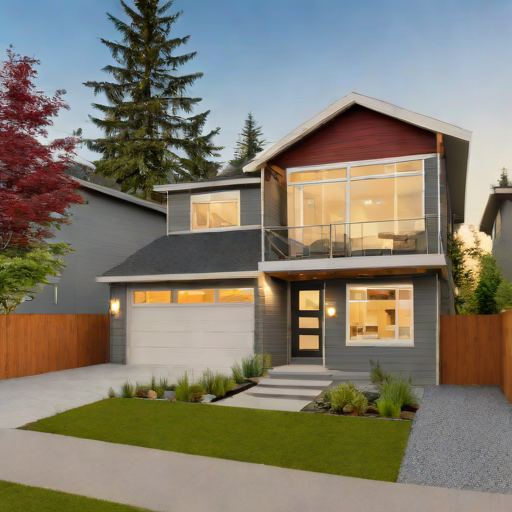

In [21]:
idx = 9
print('Description:', df.iloc[idx]['description'])
print('Neighborhood Description:', df.iloc[idx]['neighborhood_description'])
listing_images[idx]

In [22]:
for i, image in enumerate(listing_images):
    filename = os.path.join('/content/chroma', str(i) + ".png")
    image.save(filename)

In [23]:
from PIL import Image
property_images = []
property_images_paths = []

for i in range(0,21):
    image = os.path.join('/content/chroma', str(i) + ".png")
    property_images.append(Image.open(image))
    property_images_paths.append(image)

In [26]:
db.add_images(uris=property_images_paths, metadatas = property_ids)

['d464797c-10c0-11ef-8ff1-0242ac1c000c',
 'd4663e24-10c0-11ef-8ff1-0242ac1c000c',
 'd4663f14-10c0-11ef-8ff1-0242ac1c000c',
 'd4663fc8-10c0-11ef-8ff1-0242ac1c000c',
 'd466407c-10c0-11ef-8ff1-0242ac1c000c',
 'd4664126-10c0-11ef-8ff1-0242ac1c000c',
 'd46641d0-10c0-11ef-8ff1-0242ac1c000c',
 'd466427a-10c0-11ef-8ff1-0242ac1c000c',
 'd466431a-10c0-11ef-8ff1-0242ac1c000c',
 'd46643c4-10c0-11ef-8ff1-0242ac1c000c',
 'd4664464-10c0-11ef-8ff1-0242ac1c000c',
 'd466450e-10c0-11ef-8ff1-0242ac1c000c',
 'd46645a4-10c0-11ef-8ff1-0242ac1c000c',
 'd466463a-10c0-11ef-8ff1-0242ac1c000c',
 'd46646e4-10c0-11ef-8ff1-0242ac1c000c',
 'd466478e-10c0-11ef-8ff1-0242ac1c000c',
 'd4664838-10c0-11ef-8ff1-0242ac1c000c',
 'd46648f6-10c0-11ef-8ff1-0242ac1c000c',
 'd46649a0-10c0-11ef-8ff1-0242ac1c000c',
 'd4664a40-10c0-11ef-8ff1-0242ac1c000c',
 'd4664aea-10c0-11ef-8ff1-0242ac1c000c']

## Semantic Search and Response Generation

In [58]:
def get_similar_listings(user_preferences: List[str], top_k: int = 5) -> List[int]:

    combined_preferences = '\n'.join(user_preferences)
    results = db.similarity_search(combined_preferences, k=top_k * 2)

    return [result.metadata['id'] for result in results if result.metadata['id'] not in results[:top_k]]


In [60]:
instructions = 'Create a short description tailored to each listing, capturing the kind of what the buyer desires and emphasizing those key features to attract their interest.'

In [61]:
class ListingSummary(BaseModel):
    listing_id: int
    summary_text: str

class SummaryCollection(BaseModel):
    listing_summaries: List[ListingSummary]

parser = PydanticOutputParser(pydantic_object=SummaryCollection)
prompt_template = PromptTemplate(
    template="{instruction}\nBuyer Preferences:\n{buyer_preferences}\nListings:\n{listings}\n\n{format_instructions}",
    input_variables=["instruction", "buyer_preferences", "listings"],
    partial_variables={"format_instructions": parser.get_format_instructions},
)


In [62]:
cached_summaries = {}

def generate_customized_summaries(buyer_preferences: List[str], top_k: int = 5) -> List[Tuple[int, str]]:

    top_listings = get_similar_listings(buyer_preferences, top_k)

    listings = [('ID:' + str(listing_id), property_texts[listing_id]) for listing_id in top_listings]

    query = prompt_template.format(
        instruction=instructions,
        buyer_preferences='\n'.join(buyer_preferences),
        listings='\n'.join([''.join(listing) for listing in listings])
    )

    response = []
    for summary in parser.parse(model(query)).listing_summaries:
        response.append((summary.listing_id, summary.summary_text))
        cached_summaries[summary.listing_id] = summary.summary_text

    return response


In [65]:
questions = ["What type of neighborhood are you aiming for?",
             "Which house size best suits your needs?",
             "How many bed do you want?",
             "How many bath do you want?",
             "What is the price range you want?"]

ans = [
        "California",
        "2000 sqft",
        "6",
        "4",
        ""
]


In [68]:
result = generate_customized_summaries(ans)
print(result)

[(5, 'Experience the pinnacle of luxury in this Beverly Hills estate, boasting 5 bedrooms and 5.5 bathrooms across 4,000 sqft. Ideal for lavish entertaining with a pool and high-end finishes, nestled in a community known for its celebrity residents and sustainable living.'), (6, 'Discover lakeside serenity in this 3,000 sqft Lake Tahoe home with 4 bedrooms and 3.5 bathrooms. Perfect for outdoor lovers with direct lake access and surrounded by natural beauty, this home offers a life of adventure and tranquility.'), (3, 'Modern 2,600 sqft home in the heart of Silicon Valley, featuring 4 bedrooms and 3 bathrooms. With high-tech amenities and proximity to top-rated schools, this Palo Alto home is ideal for families and tech enthusiasts seeking a blend of comfort and innovation.'), (9, "Embrace Portland's vibrant lifestyle in this eco-friendly, 2,400 sqft home with 3 bedrooms and 2.5 bathrooms. Located near local markets and cafes, this home is perfect for those seeking a community-focused,

In [69]:
ans = [
        "New York",
        "1400 sqft",
        "3",
        "3",
        "2,000,000"
]

result = generate_customized_summaries(ans)
print(result)

[(1, 'Experience the pinnacle of Manhattan luxury with this 2,000 sqft apartment featuring 3 bedrooms and 2.5 bathrooms. Enjoy breathtaking city views from your private balcony, modern kitchen with high-end appliances, and an exclusive rooftop lounge. Perfect for those who seek a vibrant urban lifestyle in the heart of New York City.'), (4, 'Discover the historic charm of Charleston in this 2,200 sqft home with 3 bedrooms and 2.5 bathrooms. Enjoy classic architectural details, a gourmet kitchen, and a private garden in a neighborhood known for its rich history and cultural heritage.'), (14, 'Indulge in the vibrant lifestyle of South Beach with this 1,800 sqft contemporary condo. Offering 3 bedrooms, 2 bathrooms, and panoramic ocean views, this home is steps away from the beach and vibrant nightlife, perfect for those who love coastal living with a touch of luxury.'), (6, 'Embrace lakeside serenity in Lake Tahoe with this 3,000 sqft home featuring 4 bedrooms and 3.5 bathrooms. Enjoy pan

In [70]:
!tar chvfz real_estate_udacity.tar.gz *

chroma/
chroma/15.png
chroma/16.png
chroma/6.png
chroma/13.png
chroma/0.png
chroma/11.png
chroma/20.png
chroma/1.png
chroma/3.png
chroma/10.png
chroma/2.png
chroma/9.png
chroma/7.png
chroma/8.png
chroma/12.png
chroma/18.png
chroma/5.png
chroma/14.png
chroma/4.png
chroma/19.png
chroma/17.png
real_estate_listings.csv
requirements.txt
sample_data/
sample_data/anscombe.json
sample_data/README.md
sample_data/mnist_train_small.csv
sample_data/mnist_test.csv
sample_data/california_housing_train.csv
sample_data/california_housing_test.csv
